<a href="https://colab.research.google.com/github/pinilDissanayaka/Brain-Tumor-Classification/blob/main/notebook1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install livelossplot
! pip install visualkeras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.8/993.8 kB 13.5 MB/s eta 0:00:00


In [2]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [3]:
! kaggle datasets download masoudnickparvar/brain-tumor-mri-dataset

Dataset URL: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset
License(s): CC0-1.0
 94% 140M/149M [00:02<00:00, 45.1MB/s]
100% 149M/149M [00:02<00:00, 63.8MB/s]


In [4]:
! unzip brain-tumor-mri-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: Training/glioma/Tr-gl_0712.jpg  
  inflating: Training/glioma/Tr-gl_0713.jpg  
  inflating: Training/glioma/Tr-gl_0714.jpg  
  inflating: Training/glioma/Tr-gl_0715.jpg  
  inflating: Training/glioma/Tr-gl_0716.jpg  
  inflating: Training/glioma/Tr-gl_0717.jpg  
  inflating: Training/glioma/Tr-gl_0718.jpg  
  inflating: Training/glioma/Tr-gl_0719.jpg  
  inflating: Training/glioma/Tr-gl_0720.jpg  
  inflating: Training/glioma/Tr-gl_0721.jpg  
  inflating: Training/glioma/Tr-gl_0722.jpg  
  inflating: Training/glioma/Tr-gl_0723.jpg  
  inflating: Training/glioma/Tr-gl_0724.jpg  
  inflating: Training/glioma/Tr-gl_0725.jpg  
  inflating: Training/glioma/Tr-gl_0726.jpg  
  inflating: Training/glioma/Tr-gl_0727.jpg  
  inflating: Training/glioma/Tr-gl_0728.jpg  
  inflating: Training/glioma/Tr-gl_0729.jpg  
  inflating: Training/glioma/Tr-gl_0730.jpg  
  inflating: Training/glioma/Tr-gl_0731.jpg  
  inflating: Training/glioma/

In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import cv2 as cv
import os
import random
from glob import glob
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAvgPool2D
from tensorflow.keras.applications import ResNet50, InceptionResNetV2
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, ModelCheckpoint, ReduceLROnPlateau
from livelossplot import PlotLossesKerasTF
import visualkeras
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import class_weight

import warnings
warnings.filterwarnings(action = 'ignore')

In [6]:
trainDir="/content/Training"
testingDir="/content/Testing"

In [7]:
def getImageCount(root):
  imageFolders=glob(os.path.join(root, "*"))
  imageCountDic={}
  for folder in imageFolders:
    imageCount=len(glob(os.path.join(folder, "*")))
    imageCountDic[os.path.basename(folder)] = imageCount

  print(f"Number of output classes : {len(imageFolders)}")
  print(f"Number of images in each class : {imageCountDic}\n")

  sns.set()
  plt.figure(figsize=(10, 5))
  plt.bar(x=list(imageCountDic.keys()), height=list(imageCountDic.values()))
  plt.xlabel("Classes")
  plt.ylabel("Number of images")
  plt.title(f"Number of images in each class at {os.path.basename(root)} set.")
  plt.show()

Number of output classes : 4
Number of images in each class : {'pituitary': 1457, 'glioma': 1321, 'notumor': 1595, 'meningioma': 1339}



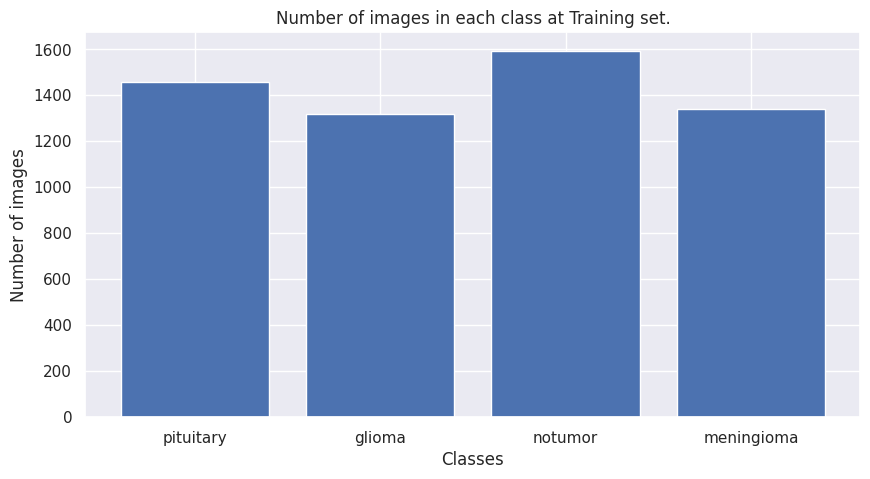

In [8]:
getImageCount(trainDir)

Number of output classes : 4
Number of images in each class : {'pituitary': 300, 'glioma': 300, 'notumor': 405, 'meningioma': 306}



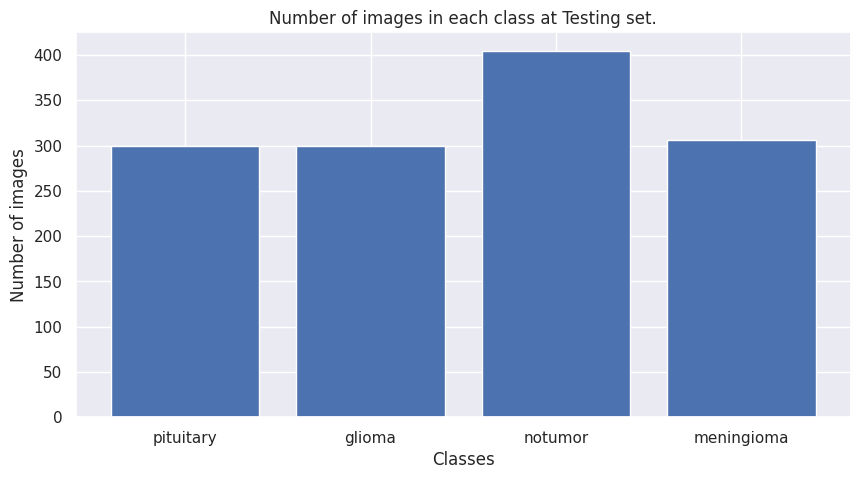

In [9]:
getImageCount(testingDir)

In [17]:
def printRandomImage(root, nrows, ncols):
  imageFolders=glob(os.path.join(root, "*"))
  for imageFolder in imageFolders:
    imagePath=glob(os.path.join(imageFolder, "*"))
    randomImages=random.choices(imagePath, k=(nrows*ncols))

    plt.figure(figsize=(15, 10))
    for i in range(nrows*ncols):
      plt.subplot(nrows, ncols, i+1)
      image=plt.imread(randomImages[i])
      plt.imshow(image)
      plt.title(os.path.basename(imageFolder))
      plt.axis("off")
    plt.show()


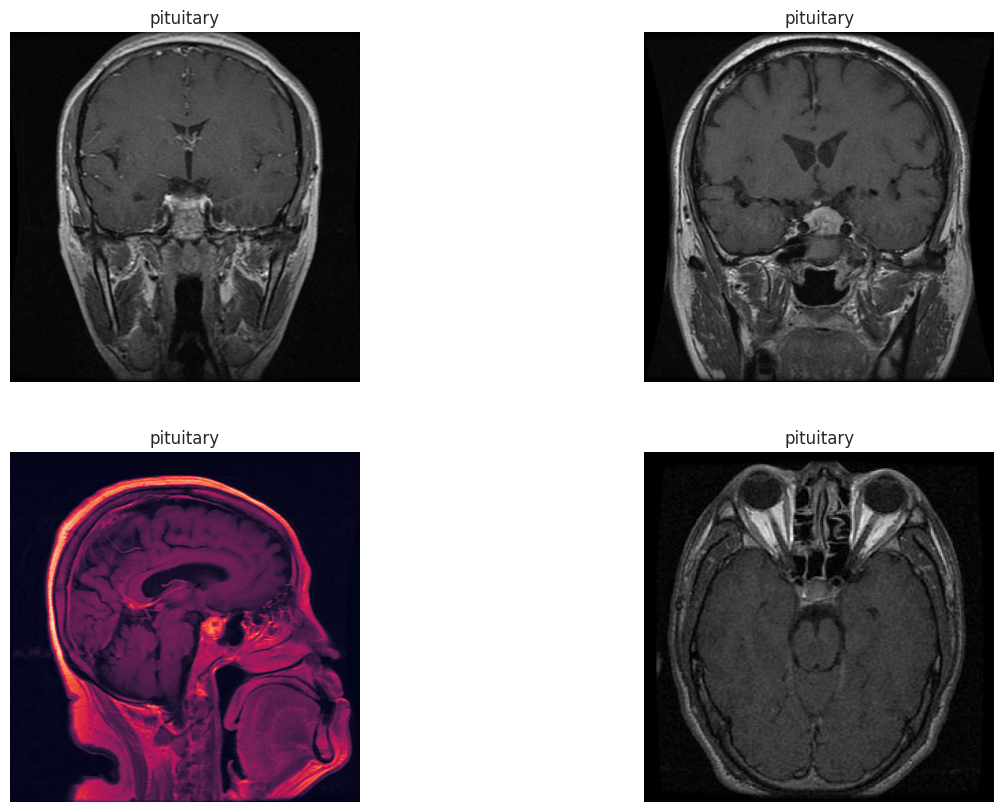

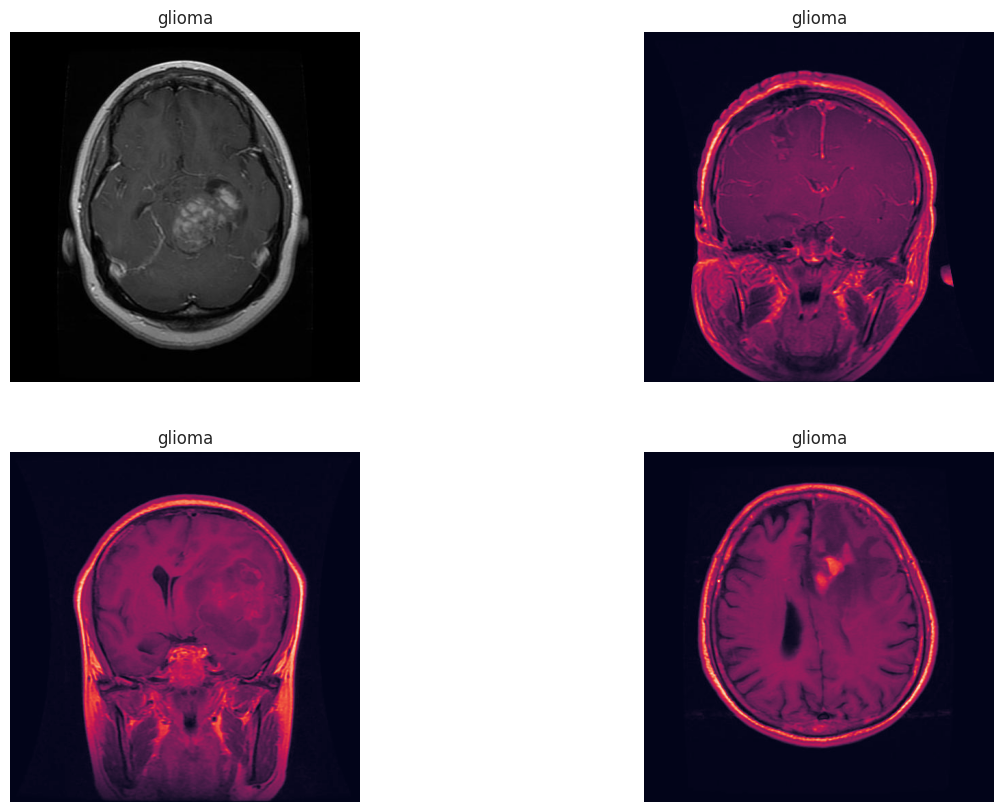

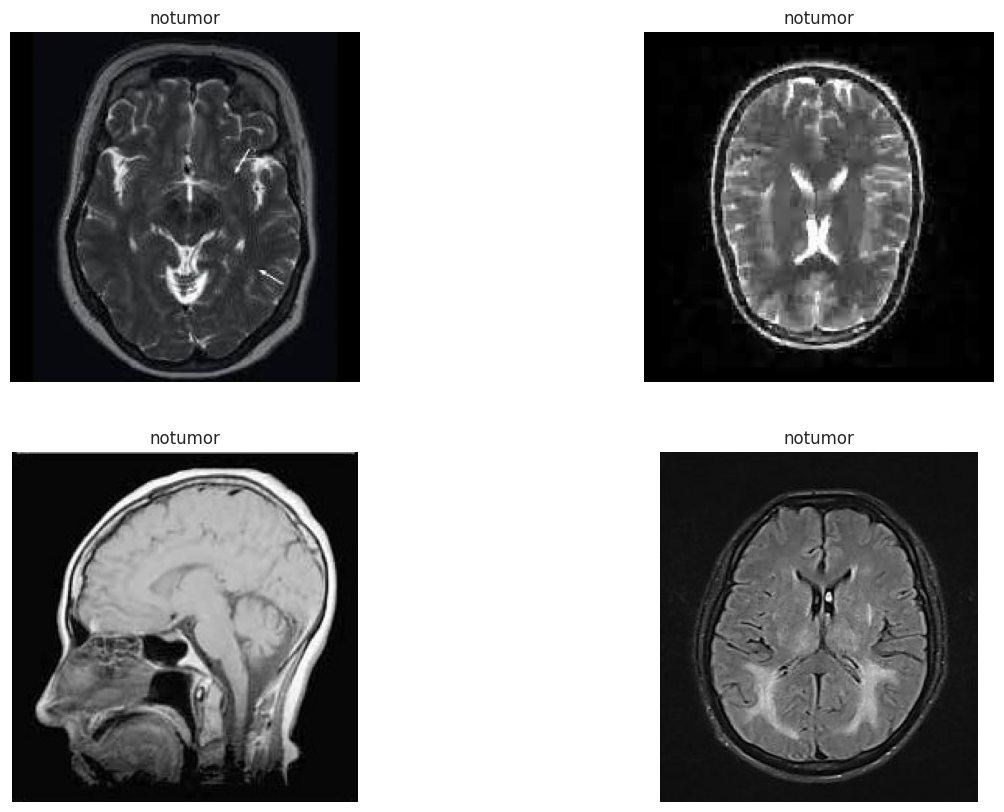

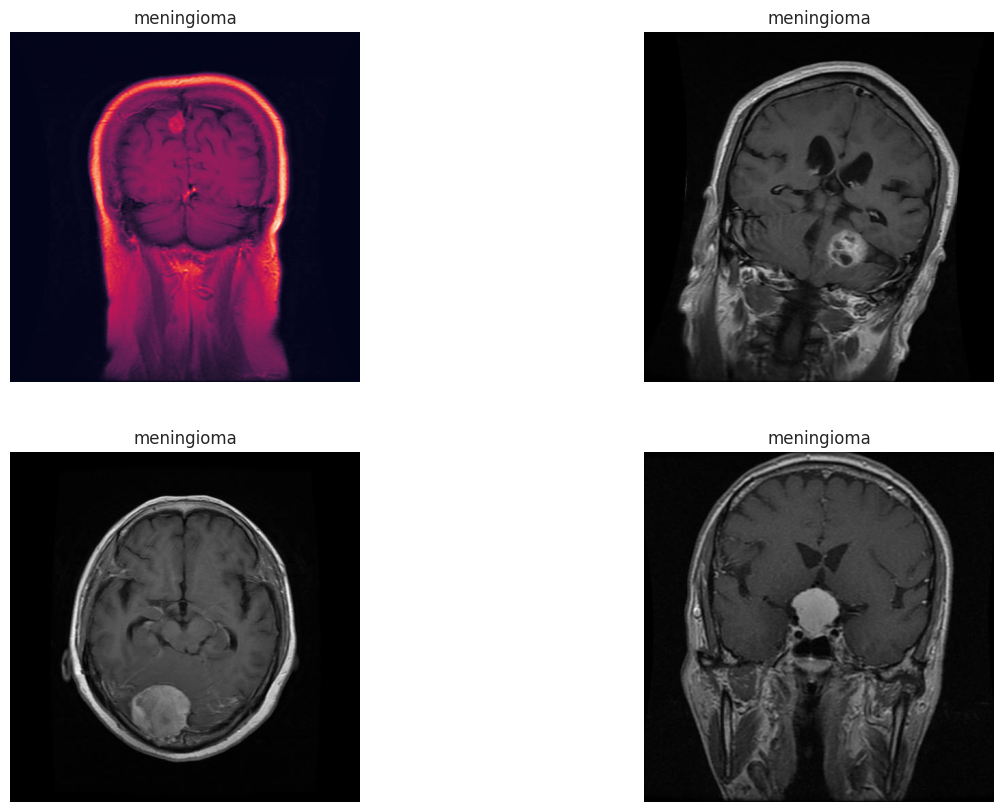

In [18]:
printRandomImage(trainDir, 2, 2)

In [19]:
def getImageSize(root)->set:
  imageSize=set()
  imageFolders=glob(os.path.join(root, "*"))
  for imageFolder in imageFolders:
    imagePathList=glob(os.path.join(imageFolder, "*"))
    for imagePath in imagePathList:
      image=plt.imread(imagePath)
      imageSize.add(image.shape)
  return imageSize

In [20]:
trainImageSize=getImageSize(trainDir)
testImageSize=getImageSize(testingDir)
print(f"Train set image size : {trainImageSize}")
print(f"Test set image size : {testImageSize}")

Train set image size : {(395, 367, 3), (717, 717, 3), (290, 236, 3), (302, 216, 3), (245, 206, 3), (512, 434, 3), (250, 201, 3), (274, 230, 3), (442, 442, 3), (228, 233, 3), (480, 853, 3), (484, 405, 3), (248, 208, 3), (417, 428, 3), (344, 320, 3), (273, 236, 3), (236, 236, 3), (244, 206, 3), (470, 469, 3), (214, 229, 3), (496, 453, 3), (216, 234, 3), (439, 645, 3), (395, 416, 3), (236, 255, 3), (342, 323, 3), (257, 235, 3), (1080, 1920, 3), (340, 507, 3), (222, 233, 3), (486, 421, 3), (260, 314, 3), (512, 416, 3), (270, 250, 3), (415, 339, 3), (301, 275, 3), (903, 721, 3), (243, 207, 3), (300, 227, 3), (372, 341, 3), (592, 562, 3), (282, 230, 3), (225, 209, 3), (306, 278, 3), (361, 642, 3), (225, 225), (355, 330, 3), (228, 236, 3), (872, 850, 3), (213, 210, 3), (223, 224, 3), (248, 200, 3), (218, 234, 3), (320, 497, 3), (320, 257, 3), (248, 257, 3), (365, 306, 3), (442, 442), (613, 605, 3), (239, 236, 3), (354, 298, 3), (258, 300, 3), (280, 236, 3), (400, 393, 4), (201, 173, 3), (228,